In [112]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from GalPop import *
from tqdm.notebook import tqdm
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [63]:
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)

In [57]:
### PREP ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

sigs = [2.0, 3.0, 4.0]
p_sums = []
for s in sigs:
    p_sums.append(np.genfromtxt(f"HyperionPeaks_new/peaks_sig{s}.dat", dtype=float))


cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

In [44]:
### CREATE INSTANCES ###

phot_pops = []
spec_pops = []

for m_iter in range(3):
    # Photo
    new_p = GalPop()
    new_p.loadFile(f"GalPops_phot/MC_{m_iter}.npy")
    phot_pops.append(new_p)

    # Spec
    new_s = GalPop()
    new_s.loadFile(f"GalPops_spec/MC_{m_iter}.npy")
    spec_pops.append(new_s)

In [4]:
tot_pop = []
for s, p in zip(spec_pops, phot_pops):
    tot = s.combine(p)
    tot_pop.append(tot)

In [5]:
# ### PHOTO-Z ###

pk_path = "HyperionPeaks_new/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]

# for idx, p in enumerate(phot_pops):

#     p.subPop("field1", [-99, 4.0], 13. , [2.2, 2.3], pk_path, pk_sums[2], sig_cube, cosmo = cosmo, plot=f"popPlots/phot_{idx}")
#     p.subPop("field2", [-99, 4.0], 13. , [2.65, 2.75], pk_path, pk_sums[2], sig_cube, cosmo = cosmo, plot=f"popPlots/phot_{idx}")

#     for si, sigma in enumerate(sigs):
#         p.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.45, 2.55], pk_path, pk_sums[si], sig_cube, plot=f"popPlots/phot_{idx}")


In [6]:
# ### SPEC-Z ###

# for idx, s in enumerate(spec_pops):

#     s.subPop("field1", [-99, 4.0], 13. , [2.2, 2.3], pk_path, pk_sums[2], sig_cube, cosmo = cosmo, plot=f"popPlots/spec_{idx}")
#     s.subPop("field2", [-99, 4.0], 13. , [2.65, 2.75], pk_path, pk_sums[2], sig_cube, cosmo = cosmo, plot=f"popPlots/spec_{idx}")

#     for si, sigma in enumerate(sigs):
#         s.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.45, 2.55], pk_path, pk_sums[si], sig_cube, plot=f"popPlots/spec_{idx}")


In [93]:
### MAKE GAL POPS ###

m_iter = 249            # Max iterations
tot_pops = []           # Store total gal pops 


for m in tqdm(range(m_iter)):
    # Load Photo
    new_p = GalPop()
    new_p.loadFile(f"GalPops_phot/MC_{m}.npy")

    # Load specs
    new_s = GalPop()
    new_s.loadFile(f"GalPops_spec/MC_{m}.npy")


    # Cut repeat gals from photos
    pids = new_s.IDs   # IDs for the spectra
    new_p.del_objs(pids)       # Delete the objects

    # Combine
    new_tot = new_s.combine(new_p)

    
    # Remove based on IRAC cut
    c_ids = new_tot.IDs.astype(int) - 1
    gals = c20p[c_ids]
    
    b_ids = np.where((gals["ALPHA_J2000"] >= ra_range[0]) & (gals["ALPHA_J2000"] <= ra_range[1]) # RA
                & (gals["DELTA_J2000"] >= dec_range[0]) & (gals["DELTA_J2000"] <= dec_range[1]) # Dec
            & (gals["IRAC_CH1_MAG"] > 25) | (gals["IRAC_CH2_MAG"] > 25))

    new_tot.del_objs(new_tot.IDs[b_ids])

    tot_pops.append(new_tot)

  0%|          | 0/249 [00:00<?, ?it/s]

In [94]:
### TOT-Z ###
pk_path = "HyperionPeaks_new/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]

for idx, t in tqdm(enumerate(tot_pops)):

    t.subPop("field1", [-99, 4.0], 13. , [2.2, 2.3], pk_path, pk_sums[2], sig_cube, cosmo = cosmo, plot=f"popPlots/tot_{idx}")
    t.subPop("field2", [-99, 4.0], 13. , [2.65, 2.75], pk_path, pk_sums[2], sig_cube, cosmo = cosmo, plot=f"popPlots/tot_{idx}")

    for si, sigma in enumerate(sigs):
        t.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.45, 2.55], pk_path, pk_sums[si], sig_cube, plot=f"popPlots/tot_{idx}")


0it [00:00, ?it/s]

In [104]:
### BUILD SMFs ###
sp_keys = [['field1', 'field2']] + [f'o{s}' for s in sigs] 
smf_keys = ['field'] + [f'o{s}' for s in sigs] 

for idx, t in enumerate(tot_pops):
    # Make SMFs #
    m_range = [9., 11.5, 0.25]
    t.make_SMF(sp_keys, smf_keys ,m_range)

    # Make fits #
    # t.fit_SMF(smf_keys, smf_keys, [1 for s in smf_keys], p0=[10, 1, -1], maxfev=3000)
    
    # t.SMF_plot(smf_keys, smf_keys, smf_keys, smf_keys, title="", plot="None")

In [131]:
id = 45
print((tot_pops[id].vols['field1'] + tot_pops[id].vols['field2']) / tot_pops[id].vols['o2.0'])
print(np.nansum(tot_pops[id].smfs['field'][:,1][:3]) / np.nansum(tot_pops[id].smfs['o2.0'][:,1][:3]))

15.600791452564597
22.568047337278106


In [138]:
def schechter(M, phi_star, alpha, m_star):
  return np.log(10)*phi_star*10**((M-m_star)*(1+alpha))*np.exp(-10**(M-m_star))

In [137]:
def Dschechter(M, M_star, phi_s1, phi_s2, alpha_1, alpha_2):
    return np.log(10)*np.exp(-10**(M-M_star))*(phi_s1*(10**(M-M_star))**(alpha_1+1) \
    +phi_s2*(10**(M-M_star))**(alpha_2+1) )

In [139]:
def C20field(m, fn):
    if fn == 0:
        return Dschechter(m, 10.78,0.27e-3, 0.27e-3, -1.46, 0.07 )
    else:
        return schechter(m, 0.24e-3, -1.46, 10.97)

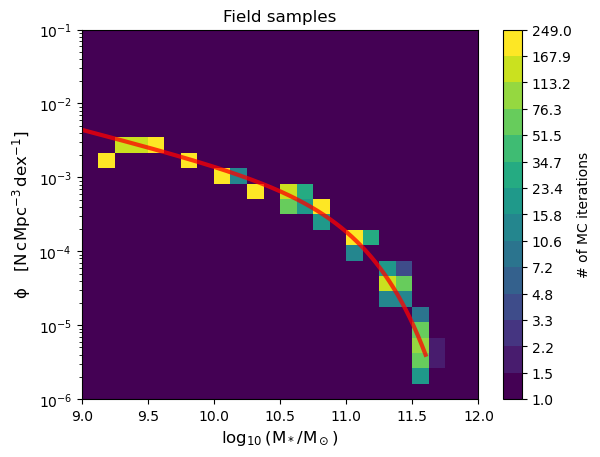

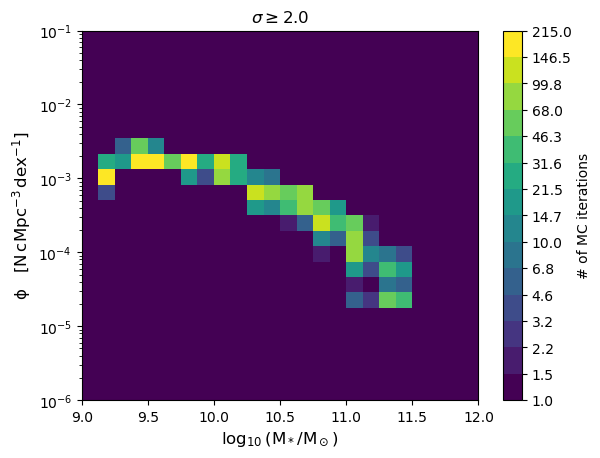

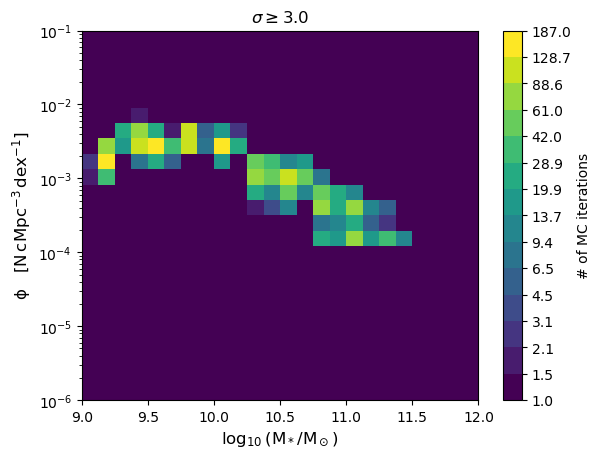

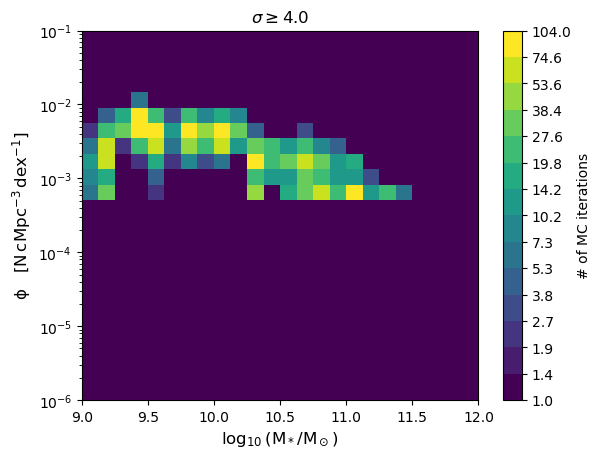

In [148]:
titles = ["Field samples", r"$\sigma \geq 2.0$", r"$\sigma \geq 3.0$", r"$\sigma \geq 4.0$"]
for ki, key in enumerate(smf_keys):
    tot_ms  = []
    tot_ns = []

    for idx, t in enumerate(tot_pops):


        tot_ms  = np.concatenate((tot_ms, t.smfs[key][:,0]), axis=0)
        tot_ns = np.concatenate((tot_ns, t.smfs[key][:,2]), axis=0)

    xbin = np.linspace(9, 12, 25)
    ybin = np.logspace(-6, -1, 25)

    fig, ax = plt.subplots()
    ms = np.linspace(9, 11.6, 1000)
    if ki == 0:
        ax.plot(ms, C20field(ms, 1), color='red', lw='3', alpha=0.75)

    # Create a 2D histogram
    hist, xedges, yedges, im = ax.hist2d(tot_ms, tot_ns, bins=(xbin, ybin), norm=LogNorm())

    # Define the number of discrete levels
    log_min = np.log10(hist[hist > 0].min())
    log_max = np.log10(hist.max())
    levels = np.logspace(log_min, log_max, num=15)

    # Use a BoundaryNorm to create discrete color levels
    norm = BoundaryNorm(levels, ncolors=plt.get_cmap('viridis').N, clip=True)

    # Plot the 2D histogram again with the discrete norm
    h = ax.hist2d(tot_ms, tot_ns, bins=(xbin, ybin), norm=norm, cmap='viridis')
    fig.colorbar(h[3], ax=ax, ticks=levels, label="# of MC iterations")
 
    ax.set(yscale='log', ylim=(1e-6, 1e-1), title=titles[ki])
    ax.set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=12)
    ax.set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=12)
    plt.show()

In [155]:
len(tot_pops[0].smfs['field'])

11

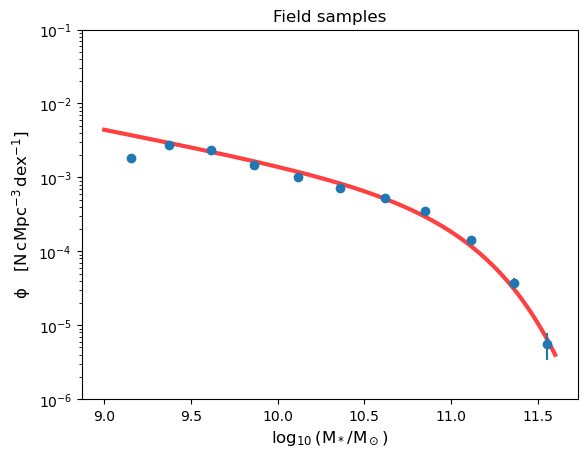

c:\Users\sikor\Anaconda3\envs\py38\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


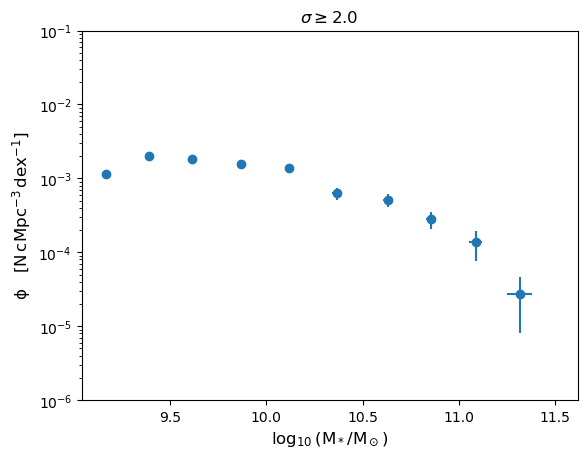

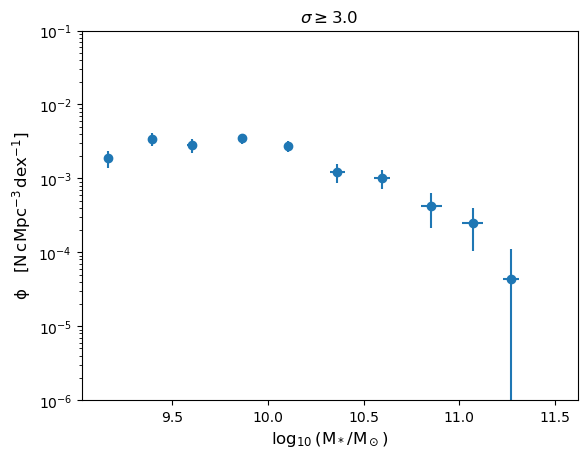

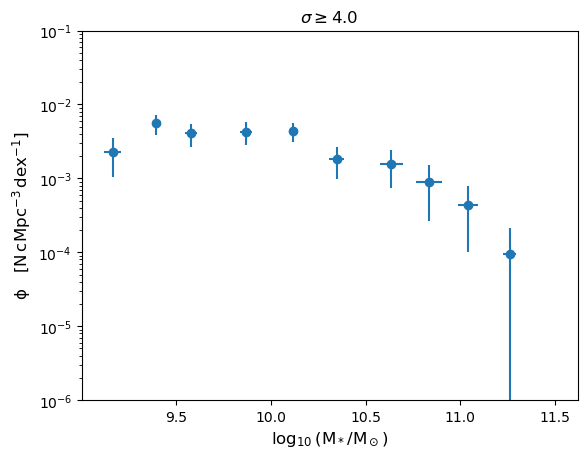

In [164]:
titles = ["Field samples", r"$\sigma \geq 2.0$", r"$\sigma \geq 3.0$", r"$\sigma \geq 4.0$"]
for ki, key in enumerate(smf_keys):
    tot_ms  = np.zeros(shape=(len(tot_pops), len(tot_pops[0].smfs['field'])))
    tot_ns = np.zeros(shape=(len(tot_pops), len(tot_pops[0].smfs['field'])))

    for idx, t in enumerate(tot_pops):


        tot_ms[idx]  = t.smfs[key][:,0]
        tot_ns[idx] = t.smfs[key][:,2]


    plot_m = []
    plot_n = []
    yerror = []
    xerror = []
    for i in range(len(tot_pops[0].smfs['field'])):
        plot_m.append(np.nansum(tot_ms[:,i])/ len(tot_ms))
        xerror.append(np.std(tot_ms[:,i]))
        plot_n.append(np.nansum(tot_ns[:,i])/len(tot_ns))
        yerror.append(np.nanstd(tot_ns[:,i]))


    xbin = np.linspace(9, 12, 25)
    ybin = np.logspace(-6, -1, 25)

    fig, ax = plt.subplots()
    ms = np.linspace(9, 11.6, 1000)
    if ki == 0:
        ax.plot(ms, C20field(ms, 1), color='red', lw='3', alpha=0.75)

    ax.errorbar(plot_m, plot_n,yerr=yerror, xerr=xerror, marker='o', ls="")
    # Plot the 2D histogram again with the discrete norm 
    ax.set(yscale='log', ylim=(1e-6, 1e-1), title=titles[ki])
    ax.set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=12)
    ax.set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=12)
    plt.show()

---
---
---
---
---


In [3]:
# Spec-z catalog
specz_cat = np.loadtxt("./Data/master_specz_COSMOS_BF_v4b.cat", dtype=object)   # Load in the data
# Fix up the formatting for the spec data-file:
new_array = []
for idx in range(specz_cat.shape[1]):
    try:
        col = specz_cat[:,idx].astype(np.float32)
    except:
        col = specz_cat[:,idx]
    new_array.append(col)

specz_cat = np.array(new_array, dtype=object)
specz_cat = np.transpose(specz_cat)

In [6]:
print(specz_cat[:,2])

['VUDS' 'VUDS' 'VUDS' ... 'DEIMOS10k' 'DEIMOS10k' 'DEIMOS10k']


In [41]:
idxs = np.where((specz_cat[:,2] == "C3VO-DEIMOS") & (specz_cat[:,0]>0)&((specz_cat[:,13]%10==3)|(specz_cat[:,13]%10==4)))[0]
print(len(idxs))

236
